<center>
    <img src="./images/mlfasp.png">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

[Applied Media Systems Group](https://www.tu-ilmenau.de/en/applied-media-systems-group/) <br>
[Technische Universität Ilmenau](https://www.tu-ilmenau.de/)

# Convolutional Autoencoder

In [21]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Oms4nkitLzE?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

A so-called Autoencoder is a neural network with unsupervised training, which means that we don't need to supply a target function. There is only a training set, which is also the target set. A convolutional autoencoder uses convolutional neural networks. 

An autoencoder maps the input signal to a lower dimensional representation using its encoder part. In this way it is similar for instance to an audio encoder, which compresses an audio signal into a representation with fewer bits than the original audio signal:

In [1]:
%%html
<a href="https://github.com/GuitarsAI/AudioCodingTutorials">https://github.com/GuitarsAI/AudioCodingTutorials</a><br>
<iframe width="560" height="315" src="https://www.youtube.com/embed/videoseries?list=PL6QnpHKwdPYjRWkWLswWmxFrDmj6leRwh" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The decoder part of an autoencoder maps the lower dimensional representation back into the higher dimensional representation. This is similar to an audio decoder, which decodes the compressed version back to an audio signal.

The reconstruction after the decoder part should be as close as possible to the original. Hence the original (the training set) is also the target.

In our Python example we simply use one 1D convolutional layer for the encoder. This corresponds to the analysis filter bank of an audio encoder.

In [2]:
%%html
<a href="https://github.com/GuitarsAI/MRSP_Notebooks">https://github.com/GuitarsAI/MRSP_Notebooks</a><br>
<iframe width="560" height="315" src="https://www.youtube.com/embed/videoseries?list=PL6QnpHKwdPYiDOUHecdZc1WPTnJ-dd0cT" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

But here we also use an activation function, the "tanh" function, which seems to work better than the sigmoid function in this application, probably because it keeps the signs. We use a "stride" or downsampling factor of N=1024, and filter kernels of size 2N. 

To obtain the same dimension as the input at the encoder output, which is a critical sampled filter bank, we need N filters, or N "out_channels".

But because we want to reduce the dimensionality after encoding, we choose a lower number, which makes it an over-critically sampled filter bank, for instance "out_channels=32". This is similar to an audio coder where we simply drop the filter subbands with the highest frequencies.

We still have to choose the "padding", meaning the number of zeros which we pad before and after our audio signal before the convolution (or rather correlation in Pytorch). To align the output of the decoder with the input signal for the case of symmetric filter kernels (impulse responses), we need a padding of *filter-length/2-1*, or *kernel_size/2-1)*, because then the filtering starts with the first sample at the center of the filter, which corresponds to the the position where the filter outputs the correspondingly filtered sample, for both encoder and decoder.

Hence in Python our encoder convolutional layer example becomes:

```python
self.conv1=nn.Conv1d(in_channels=1, out_channels=32, 
                     kernel_size=2048, stride=1024, padding=1023, 
                     bias=True) #Padding for 'same' filters (kernel_size/2-1)
```

Observe that we have 1 input channel (the audio signal), and 32 output channels (the subbands).

For the decoder part we need a synthesis filter bank, which in neural network literature is also called a transposed convolutional layer, in pytorch "ConvTranspose1d":

```python
self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, 
                                 kernel_size=2048, stride=1024, padding=1023, bias=True)
```

Observe that for this synthesis filter bank we have 32 input channels (the subbands) and 1 output channel (the reconstructed audio signal).

The function for the encoder is now:

```python
def encoder(self, x):
    #Analysis:
    x = self.conv1(x)
    y = torch.tanh(x)
    return y
```

Observe that here we included the tanh activation function, which can also be seen as a range limiter (between -1 and 1).

For the decoder it is:

```python
def decoder(self, y):
    #Synthesis:
    xrek= self.synconv1(y)
    return xrek
```

For both together it becomes the overall autoencoder:

```python
def forward(self, x):
    y=self.encoder(x)
    #y=torch.round(y/0.125)*0.125
    xrek=self.decoder(y)
    return xrek
```

We put these functions in a class "Convautoenc":

```python
class Convautoenc(nn.Module):
```

For the training we use the input signal also as a target. There we have to limit the length to the signal length produced by the model output, which we can simply obtain by letting the model run once before the training:

```python
model = Convautoenc()
Ypred=model(X)
outputlen=len(Ypred[0,0,:])
Y=X[:,:,:outputlen]
```

Y is the target signal with same length as model output.

As loss function a common choice is the Mean Squared Error, even though it might not be optimal:

```python
loss_fn = nn.MSELoss()
```

The training is then done with with the for loop:

```python
for epoch in range(2000):
    Ypred=model(X)
    loss=loss_fn(Ypred, Y)
    if epoch%10==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

In [22]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/0pPrUF08s58?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [3]:
# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'

"""
convolutional autoencoder for audio signals.
Gerald Schuller, February 2020.
""";
#Ported to Jupyter Notebooks by Renato Profeta, October 2020

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa

In [5]:
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle
   
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device) 

device= cpu


In [6]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [7]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [8]:
#alternative: speech:
batch=1
audio, samplerate = librosa.load("./audio/ACDC - Back In Black Intro.wav", mono=False, sr=None, offset=6)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension    
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension    

In [9]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()
    
Ypred=model(X_train)
   
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 881666
Input X.shape= torch.Size([1, 1, 882000])
Target Y.shape= torch.Size([1, 1, 881666])
Target Y= tensor([[[-0.0021,  0.0010,  0.0031,  ..., -0.0969, -0.0991, -0.0316]]])
Y.type()= torch.FloatTensor


In [10]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(10000):
        Ypred=model(X_train)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[0.0190, 0.0195, 0.0199,  ..., 0.0126, 0.0177, 0.0222]]],
       grad_fn=<SqueezeBackward1>)
0 0.013286784291267395
10 0.013005847111344337
20 0.012571677565574646
30 0.011936426162719727
40 0.011214710772037506
50 0.010525964200496674
60 0.009904185310006142
70 0.009359524585306644
80 0.008895388804376125
90 0.00850263424217701
100 0.008169475942850113
110 0.007883605547249317
120 0.007633186411112547
130 0.007409087847918272
140 0.0072054313495755196
150 0.007018646225333214
160 0.006846345029771328
170 0.006686599925160408
180 0.00653761625289917
190 0.006397718098014593
200 0.00626541581004858
210 0.006139515433460474
220 0.00601913221180439
230 0.005903672426939011
240 0.0057927933521568775
250 0.0056863026693463326
260 0.005584137514233589
270 0.005486267618834972
280 0.005392665043473244
290 0.005303249694406986
300 0.0052179149352014065
310 0.005136477295309305
320 0.005058744456619024
330 0.004984511993825436
340 0.004913556855171919
350 0.004845664836466312
36

3110 0.00285717798396945
3120 0.0028566389810293913
3130 0.0028561025392264128
3140 0.0028555686585605145
3150 0.002855036174878478
3160 0.002854505553841591
3170 0.002853977493941784
3180 0.002853450831025839
3190 0.0028529269620776176
3200 0.002852404024451971
3210 0.0028518822509795427
3220 0.002851364901289344
3230 0.0028508484829217196
3240 0.002850332297384739
3250 0.0028498193714767694
3260 0.0028493073768913746
3270 0.0028487981762737036
3280 0.002848289208486676
3290 0.0028477832674980164
3300 0.0028472801204770803
3310 0.0028467755764722824
3320 0.002846274757757783
3330 0.0028457753360271454
3340 0.002845277078449726
3350 0.0028447825461626053
3360 0.002844286849722266
3370 0.00284379324875772
3380 0.0028433019760996103
3390 0.002842813730239868
3400 0.0028423257172107697
3410 0.002841837238520384
3420 0.0028413531836122274
3430 0.002840869827196002
3440 0.0028403871692717075
3450 0.002839906606823206
3460 0.0028394286055117846
3470 0.0028389496728777885
3480 0.0028384735342

6200 0.0027567315846681595
6210 0.002756601432338357
6220 0.0027564209885895252
6230 0.00275626708753407
6240 0.0027561199385672808
6250 0.002756002824753523
6260 0.0027558167930692434
6270 0.0027556547429412603
6280 0.0027555048000067472
6290 0.0027553695254027843
6300 0.002755231224000454
6310 0.0027550640515983105
6320 0.0027549080550670624
6330 0.002754759043455124
6340 0.0027546363417059183
6350 0.0027544687036424875
6360 0.002754330402240157
6370 0.0027542333118617535
6380 0.0027540449518710375
6390 0.0027538880240172148
6400 0.002753739943727851
6410 0.002753596054390073
6420 0.0027534880209714174
6430 0.0027533136308193207
6440 0.002753175562247634
6450 0.0027530493680387735
6460 0.0027529187500476837
6470 0.0027527541387826204
6480 0.0027526102494448423
6490 0.00275247055105865
6500 0.0027523322496563196
6510 0.0027521986048668623
6520 0.002752096625044942
6530 0.0027519301511347294
6540 0.002751785097643733
6550 0.0027516530826687813
6560 0.002751561813056469
6570 0.002751406

9300 0.002727435901761055
9310 0.002727213315665722
9320 0.0027270677965134382
9330 0.0027270116843283176
9340 0.002726952312514186
9350 0.0027268962003290653
9360 0.002726842649281025
9370 0.0027267879340797663
9380 0.0027267776895314455
9390 0.0027267441619187593
9400 0.002726631471887231
9410 0.0027265825774520636
9420 0.0027265255339443684
9430 0.002726471982896328
9440 0.0027265038806945086
9450 0.0027264049276709557
9460 0.0027263283263891935
9470 0.002726266160607338
9480 0.0027262060903012753
9490 0.0027261520735919476
9500 0.0027261031791567802
9510 0.0027262375224381685
9520 0.002726159291341901
9530 0.0027259832713752985
9540 0.0027259185444563627
9550 0.0027258528862148523
9560 0.002725795144215226
9570 0.002725746249780059
9580 0.0027256947942078114
9590 0.0027256442699581385
9600 0.00272559467703104
9610 0.0027255434542894363
9620 0.0027255243621766567
9630 0.002725502010434866
9640 0.0027254645247012377
9650 0.0027253730222582817
9660 0.0027253106236457825
9670 0.0027252

ww= OrderedDict([('conv1.weight', tensor([[[-0.1497, -0.0608,  0.0498,  ...,  0.0295,  0.0840,  0.1362]],

        [[-0.0117, -0.0396, -0.0305,  ..., -0.0061,  0.0006,  0.0075]],

        [[ 0.0493, -0.0147, -0.0069,  ...,  0.0035, -0.0459, -0.2108]],

        ...,

        [[-0.0937,  0.0210,  0.0355,  ..., -0.0192,  0.0360,  0.1116]],

        [[-0.0117,  0.0589,  0.0408,  ...,  0.0044,  0.0377,  0.0717]],

        [[ 0.0137, -0.0328, -0.0062,  ..., -0.0683,  0.0162,  0.1163]]])), ('conv1.bias', tensor([ 2.3623e-03,  5.2971e-04,  4.1242e-04, -3.7792e-04, -2.4384e-04,
        -1.2620e-03,  2.6369e-03,  2.6481e-03, -3.4014e-05, -6.1930e-04,
        -9.0759e-04, -2.1086e-05,  1.0887e-03,  4.9617e-04, -1.8023e-03,
         2.1309e-03, -2.1145e-03,  1.5606e-04,  4.0064e-04, -6.5877e-04,
        -7.5519e-05, -8.4855e-04, -2.4856e-04, -6.0559e-04, -7.2433e-04,
        -4.0227e-04,  1.8264e-03, -7.8441e-04, -8.6156e-04, -1.4335e-03,
        -8.2504e-04, -2.2862e-03])), ('synconv1.weight', te

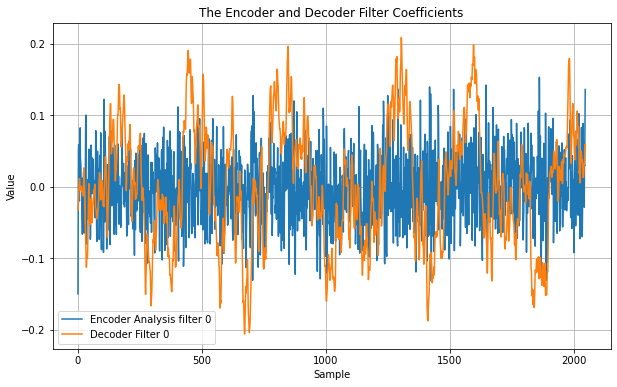

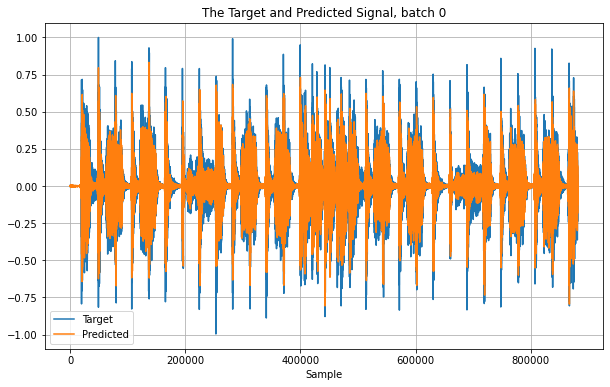

In [11]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""
    
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

#Test on training set:
predictions=model(X_train).cpu() # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
for b in range(batch):
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

In [12]:
import IPython.display as ipd
display(ipd.Audio(xrek, rate=samplerate));

Observe that here the difference is clearly big.

Observe that it is very noisy.

In this way, the autoencoder can be seen as a kind of a filter. It learns a low dimensional subspace from the training set. Every new input is mapped onto this subspace. If it doesn't quite fit onto this subspace, major elements might be missing.

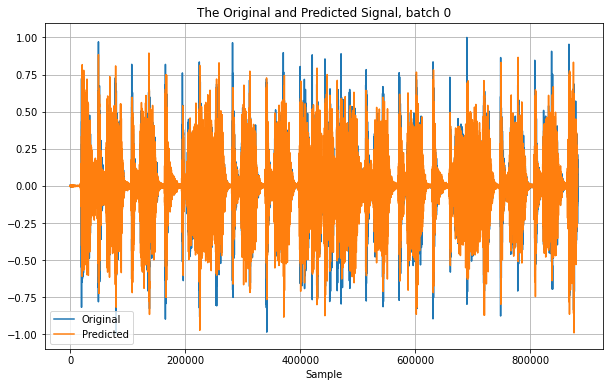

In [13]:
#Test on Verification set:
predictions=model(X_test).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
plt.figure(figsize=(10,6))
for b in range(batch):
    plt.plot(np.array(X_test[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()
xrek=predictions[:,0,:]

In [14]:
display(ipd.Audio(xrek, rate=samplerate));

## Effects of Signal Shifts

In [23]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/jop168eHqTo?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Observe the stride we used in our autoencoder. The stride corresponds to the down and up-sampling rate of the corresponding filter bank. This sampling together with the convolution has the effect of processing the signal in blocks of size of the stride. 

If we now shift our input signal by prepending the number of stride zeros at the beginning (hence delaying it by "stride" samples), we will get the same blocks, just one block later. But if we prepend a number of zeros which is not an integer multiple of the stride, the blocks will look different, and hence the result will look different, not just shifted.

In our example we can observe this by testing the trained autoencoder first with **100 zeros** added at the beginning of the training signal. The output appears **noisy**.

In [15]:
#Test on shifted input:
X_train_shifted_100 = nn.ConstantPad1d(100, 0)(X_train)
predictions=model(X_train_shifted_100).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]

In [16]:
display(ipd.Audio(xrek, rate=samplerate));

Then we add **1024 zeros** at the beginning of the signal. The output is a **bit more clear** again.

In [19]:
#Test on 1024 samples shifted test set (shift identical to the stride size)
X_train_shifted_1024 = nn.ConstantPad1d(1024, 0)(X_train)
predictions=model(X_train_shifted_1024).cpu() # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]

In [20]:
display(ipd.Audio(xrek, rate=samplerate));

This behaviour might be desired, if a certain position or timing is important, but often it is not desired. A straightforward remedy is to set stride=1. But this leads to a much higher computational complexity for training and testing or inference. As a compromise, we reduce the stride to a small value, for instance stride=16. This has lower complexity, and not much audible shift sensitivity.

Try it by setting stride=16 in both the encoder analysis part and the decoder synthesis part of the autoencoder network in the program.

Now, also the **other signal** from the verification set is much **less noisy**, as is the 100 samples shifted version, although there is still a little noise audible.

But it takes much longer for the training.